# CMS Light Dataset - Data Quality Investigation

**Purpose:** Deep dive investigation into data quality issues detected in EDA

**Focus Areas:**
1. Payment amount outliers validation
2. Extreme value investigation ($100B payment)
3. Missing data patterns
4. Geographic code validation
5. Distribution analysis

---

## Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Light Dataset

In [2]:
# Load the light dataset from CSV
data_path = Path('../data/lightdataset.csv')

if not data_path.exists():
    print(f"Error: File not found at {data_path.absolute()}")
else:
    print(f"Loading data from: {data_path.absolute()}")
    df = pd.read_csv(data_path)
    
    print(f"\nDataset loaded successfully")
    print(f"  Rows: {df.shape[0]:,}")
    print(f"  Columns: {df.shape[1]}")
    print(f"  Memory: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Loading data from: d:\Personal\AI-Admissions\Semester5\AAI-540-Machine Learning Operations\Final Team Project\aai540_3proj\notebooks\..\data\lightdataset.csv

Dataset loaded successfully
  Rows: 1,000,000
  Columns: 91
  Memory: 3595.55 MB


In [3]:
# Quick preview
print("Dataset Preview:")
display(df.head())

print("\nColumn Names:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

Dataset Preview:


,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Covered_Recipient_Profile_ID,Covered_Recipient_NPI,Covered_Recipient_First_Name,Covered_Recipient_Middle_Name,Covered_Recipient_Last_Name,Covered_Recipient_Name_Suffix,Recipient_Primary_Business_Street_Address_Line1,Recipient_Primary_Business_Street_Address_Line2,Recipient_City,Recipient_State,Recipient_Zip_Code,Recipient_Country,Recipient_Province,Recipient_Postal_Code,Covered_Recipient_Primary_Type_1,Covered_Recipient_Primary_Type_2,Covered_Recipient_Primary_Type_3,Covered_Recipient_Primary_Type_4,Covered_Recipient_Primary_Type_5,Covered_Recipient_Primary_Type_6,Covered_Recipient_Specialty_1,Covered_Recipient_Specialty_2,Covered_Recipient_Specialty_3,Covered_Recipient_Specialty_4,Covered_Recipient_Specialty_5,Covered_Recipient_Specialty_6,Covered_Recipient_License_State_code1,Covered_Recipient_License_State_code2,Covered_Recipient_License_State_code3,Covered_Recipient_License_State_code4,Covered_Recipient_License_State_code5,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Total_Amount_of_Payment_USDollars,Date_of_Payment,Number_of_Payments_Included_in_Total_Amount,Form_of_Payment_or_Transfer_of_Value,Nature_of_Payment_or_Transfer_of_Value,City_of_Travel,State_of_Travel,Country_of_Travel,Physician_Ownership_Indicator,Third_Party_Payment_Recipient_Indicator,Name_of_Third_Party_Entity_Receiving_Payment_or_Transfer_of_Value,Charity_Indicator,Third_Party_Equals_Covered_Recipient_Indicator,Contextual_Information,Delay_in_Publication_Indicator,Record_ID,Dispute_Status_for_Publication,Related_Product_Indicator,Covered_or_Noncovered_Indicator_1,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1,Product_Category_or_Therapeutic_Area_1,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1,Associated_Drug_or_Biological_NDC_1,Associated_Device_or_Medical_Supply_PDI_1,Covered_or_Noncovered_Indicator_2,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2,Product_Category_or_Therapeutic_Area_2,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2,Associated_Drug_or_Biological_NDC_2,Associated_Device_or_Medical_Supply_PDI_2,Covered_or_Noncovered_Indicator_3,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3,Product_Category_or_Therapeutic_Area_3,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_3,Associated_Drug_or_Biological_NDC_3,Associated_Device_or_Medical_Supply_PDI_3,Covered_or_Noncovered_Indicator_4,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4,Product_Category_or_Therapeutic_Area_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Associated_Device_or_Medical_Supply_PDI_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Associated_Device_or_Medical_Supply_PDI_5,Program_Year,Payment_Publication_Date
0,NEW,Covered Recipient Physician,NaN,NaN,NaN,219344.00,1821198599.00,MARK,NaN,LOOMUS,NaN,1601 BRIGHAM DR,SUITE 150,PERRYSBURG,OH,43551-7114,United States,NaN,NaN,Medical Doctor,NaN,NaN,NaN,NaN,NaN,Allopathic & Osteopathic Physicians|Psychiatry...,NaN,NaN,NaN,NaN,NaN,MI,NaN,NaN,NaN,NaN,ABBVIE INC.,100000000204,ABBVIE INC.,IL,United States,12.57,11/13/2024,1,In-kind items and services,Food and Beverage,NaN,NaN,NaN,No,No Third Party Payment,NaN,NaN,NaN,NaN,No,1104899851,No,Yes,Covered,Drug,NEUROSCIENCE,UBRELVY,0023-6501-10,NaN,Covered,Drug,NEUROSCIENCE,QULIPTA,0074-7094-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,06/30/2025
1,NEW,Covered Recipient Physician,NaN,NaN,NaN,673373.00,1881673978.00,


Column Names:
   1. Change_Type
   2. Covered_Recipient_Type
   3. Teaching_Hospital_CCN
   4. Teaching_Hospital_ID
   5. Teaching_Hospital_Name
   6. Covered_Recipient_Profile_ID
   7. Covered_Recipient_NPI
   8. Covered_Recipient_First_Name
   9. Covered_Recipient_Middle_Name
  10. Covered_Recipient_Last_Name
  11. Covered_Recipient_Name_Suffix
  12. Recipient_Primary_Business_Street_Address_Line1
  13. Recipient_Primary_Business_Street_Address_Line2
  14. Recipient_City
  15. Recipient_State
  16. Recipient_Zip_Code
  17. Recipient_Country
  18. Recipient_Province
  19. Recipient_Postal_Code
  20. Covered_Recipient_Primary_Type_1
  21. Covered_Recipient_Primary_Type_2
  22. Covered_Recipient_Primary_Type_3
  23. Covered_Recipient_Primary_Type_4
  24. Covered_Recipient_Primary_Type_5
  25. Covered_Recipient_Primary_Type_6
  26. Covered_Recipient_Specialty_1
  27. Covered_Recipient_Specialty_2
  28. Covered_Recipient_Specialty_3
  29. Covered_Recipient_Specialty_4
  30. Covered_Recip

## 2. Issue #1: Payment Amount Outliers Validation

**Question:** Is the $100 billion payment real or a data error?

In [4]:
# Identify payment column
payment_cols = [col for col in df.columns if 'amount' in col.lower() and 'payment' in col.lower()]
print("Available payment columns:")
for col in payment_cols:
    print(f"  - {col}")

# Use the main payment column
payment_col = 'Total_Amount_of_Payment_USDollars' if 'Total_Amount_of_Payment_USDollars' in df.columns else payment_cols[0]
print(f"\nUsing column: {payment_col}")

Available payment columns:
  - Total_Amount_of_Payment_USDollars
  - Number_of_Payments_Included_in_Total_Amount

Using column: Total_Amount_of_Payment_USDollars


In [5]:
# Payment amount statistics
print("=" * 80)
print("PAYMENT AMOUNT ANALYSIS")
print("=" * 80)

payments = df[payment_col].dropna()

print(f"\nTotal Records: {len(df):,}")
print(f"Non-null Payments: {len(payments):,} ({len(payments)/len(df)*100:.1f}%)")
print(f"Missing Payments: {df[payment_col].isnull().sum():,} ({df[payment_col].isnull().sum()/len(df)*100:.1f}%)")

print(f"\nBasic Statistics:")
print(f"  Min:    ${payments.min():,.2f}")
print(f"  Max:    ${payments.max():,.2f}")
print(f"  Mean:   ${payments.mean():,.2f}")
print(f"  Median: ${payments.median():,.2f}")
print(f"  Std:    ${payments.std():,.2f}")

print(f"\nPercentiles:")
for p in [25, 50, 75, 90, 95, 99, 99.9, 99.99]:
    val = payments.quantile(p/100)
    print(f"  {p:5.2f}%: ${val:>20,.2f}")

print(f"\nDistribution Shape:")
print(f"  Skewness: {payments.skew():.2f}")
print(f"  Kurtosis: {payments.kurtosis():.2f}")

PAYMENT AMOUNT ANALYSIS

Total Records: 1,000,000
Non-null Payments: 1,000,000 (100.0%)
Missing Payments: 0 (0.0%)

Basic Statistics:
  Min:    $0.01
  Max:    $13,180,782.34
  Mean:   $206.45
  Median: $20.37
  Std:    $15,089.80

Percentiles:
  25.00%: $               15.31
  50.00%: $               20.37
  75.00%: $               29.03
  90.00%: $              119.78
  95.00%: $              240.00
  99.00%: $            3,120.00
  99.90%: $           14,210.01
  99.99%: $          134,865.01

Distribution Shape:
  Skewness: 704.52
  Kurtosis: 590463.15


### Investigate Top 20 Payments

In [6]:
# Examine the largest payments
print("TOP 20 PAYMENTS - DETAILED INVESTIGATION")
print("=" * 80)

cols_of_interest = [
    payment_col,
    'Covered_Recipient_Type',
    'Recipient_State',
    'Nature_of_Payment_or_Transfer_of_Value',
    'Form_of_Payment_or_Transfer_of_Value',
    'Covered_Recipient_Profile_ID'
]

# Filter to existing columns
available_cols = [col for col in cols_of_interest if col in df.columns]

top_20 = df.nlargest(20, payment_col)[available_cols]
display(top_20)

# Summary of top 20
print(f"\nTop 20 Summary:")
print(f"  Total value: ${top_20[payment_col].sum():,.2f}")
print(f"  Percentage of all payments: {top_20[payment_col].sum() / payments.sum() * 100:.2f}%")

TOP 20 PAYMENTS - DETAILED INVESTIGATION


,Total_Amount_of_Payment_USDollars,Covered_Recipient_Type,Recipient_State,Nature_of_Payment_or_Transfer_of_Value,Form_of_Payment_or_Transfer_of_Value,Covered_Recipient_Profile_ID
375354,13180782.34,Covered Recipient Teaching Hospital,MA,Royalty or License,Cash or cash equivalent,NaN
511553,3999851.00,Covered Recipient Teaching Hospital,MI,Royalty or License,Cash or cash equivalent,NaN
222882,3431676.01,Covered Recipient Physician,NC,Acquisitions,Cash or cash equivalent,46018.00
502327,1912453.10,Covered Recipient Physician,WA,Royalty or License,Cash or cash equivalent,8797831.00
585355,1801939.07,Covered Recipient Physician,TN,Royalty or License,Cash or cash equivalent,1141140.00
959174,1693786.69,Covered Recipient Teaching Hospital,MA,Royalty or License,Cash or cash equivalent,NaN
646520,1210004.00,Covered Recipient Physician,WI,Royalty or License,Cash or cash equivalent,1202439.00
759517,999893.00,Covered Recipient Teaching Hospital,TX,Royalty or License,Cash or cash equivalent,NaN
718039,812607.77,Covered Recipient Physician,IL,Royalty or License,Cash or cash equivalent,234295.00
640144,737538.62,Covered Recipient Physician,CO,Royalty or License,Cash or cash equivalent,213507.00



Top 20 Summary:
  Total value: $35,973,302.18
  Percentage of all payments: 17.42%


### Visual Distribution Analysis

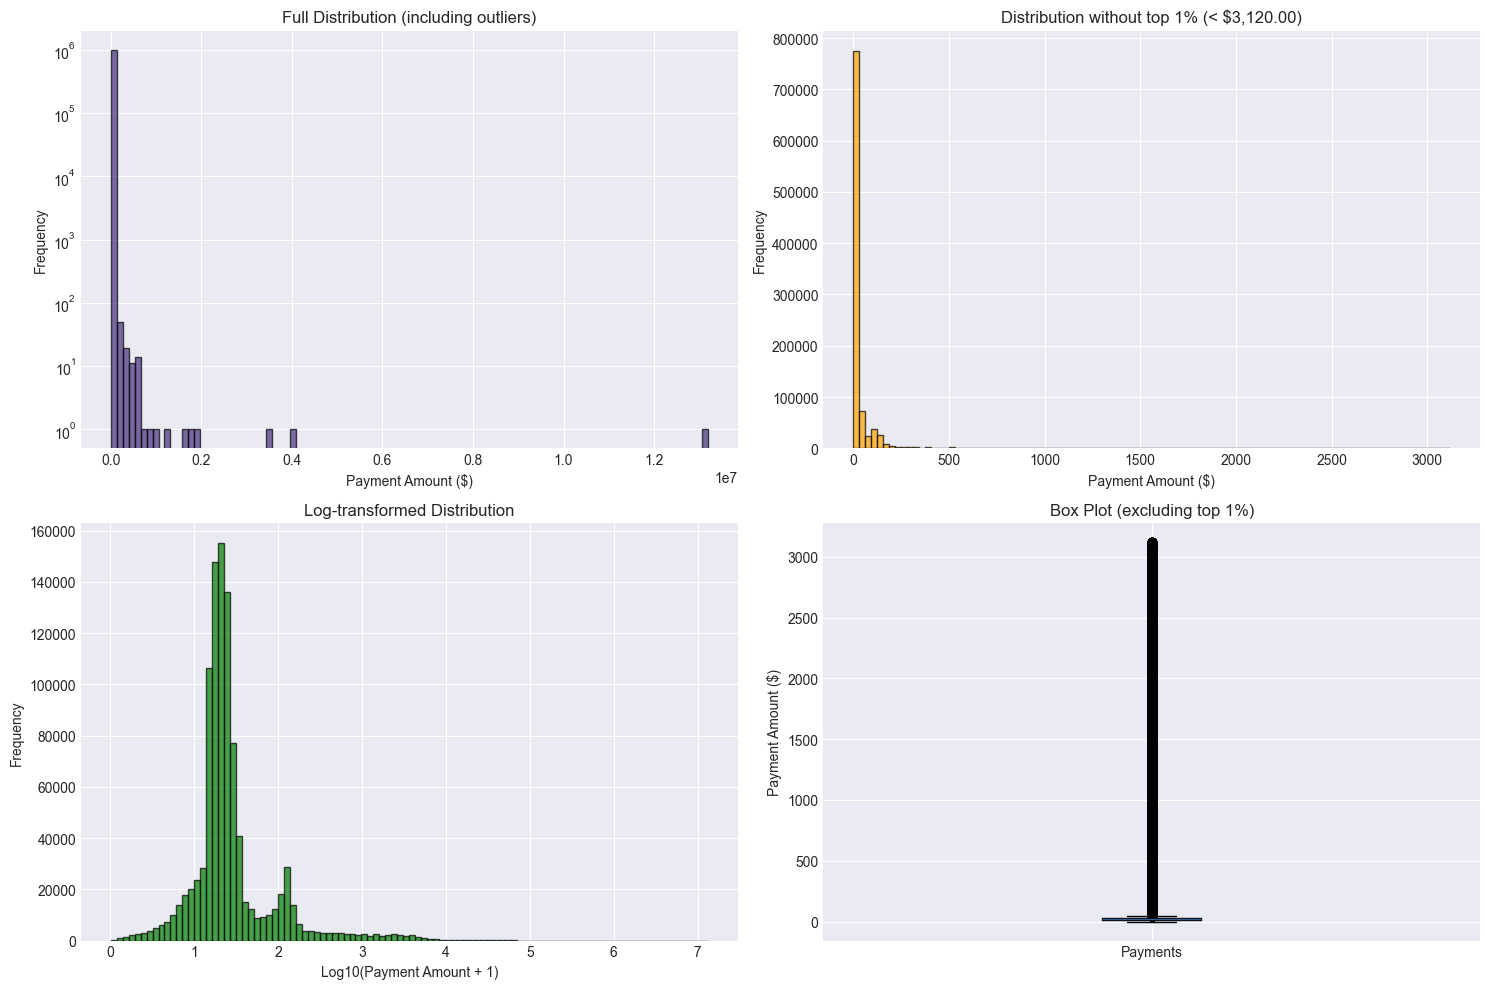


✓ Visualizations created


In [7]:
# Create visualization of payment distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Full distribution (with outliers)
axes[0, 0].hist(payments, bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Payment Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Full Distribution (including outliers)')
axes[0, 0].set_yscale('log')

# 2. Distribution without top 1%
p99 = payments.quantile(0.99)
filtered = payments[payments <= p99]
axes[0, 1].hist(filtered, bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Payment Amount ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Distribution without top 1% (< ${p99:,.2f})')

# 3. Log-scale distribution
log_payments = np.log10(payments + 1)
axes[1, 0].hist(log_payments, bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Log10(Payment Amount + 1)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Log-transformed Distribution')

# 4. Box plot
axes[1, 1].boxplot([payments[payments <= p99]], vert=True)
axes[1, 1].set_ylabel('Payment Amount ($)')
axes[1, 1].set_title('Box Plot (excluding top 1%)')
axes[1, 1].set_xticklabels(['Payments'])

plt.tight_layout()
plt.show()

print(f"\n✓ Visualizations created")

## 3. Issue #2: Outlier Detection Method Comparison

In [8]:
# Compare different outlier detection methods
print("=" * 80)
print("OUTLIER DETECTION METHOD COMPARISON")
print("=" * 80)

# Method 1: IQR (Traditional)
Q1 = payments.quantile(0.25)
Q3 = payments.quantile(0.75)
IQR = Q3 - Q1
lower_iqr = Q1 - 1.5 * IQR
upper_iqr = Q3 + 1.5 * IQR
iqr_outliers = payments[(payments < lower_iqr) | (payments > upper_iqr)]

print(f"\n1. IQR Method (1.5 × IQR):")
print(f"   Q1 = ${Q1:,.2f}")
print(f"   Q3 = ${Q3:,.2f}")
print(f"   IQR = ${IQR:,.2f}")
print(f"   Lower bound: ${lower_iqr:,.2f}")
print(f"   Upper bound: ${upper_iqr:,.2f}")
print(f"   Outliers: {len(iqr_outliers):,} ({len(iqr_outliers)/len(payments)*100:.2f}%)")
print(f"   Issue: IQR range too narrow for this distribution")

# Method 2: Modified IQR (3.0 × IQR - more lenient)
lower_iqr_mod = Q1 - 3.0 * IQR
upper_iqr_mod = Q3 + 3.0 * IQR
iqr_mod_outliers = payments[(payments < lower_iqr_mod) | (payments > upper_iqr_mod)]

print(f"\n2. Modified IQR Method (3.0 × IQR):")
print(f"   Lower bound: ${lower_iqr_mod:,.2f}")
print(f"   Upper bound: ${upper_iqr_mod:,.2f}")
print(f"   Outliers: {len(iqr_mod_outliers):,} ({len(iqr_mod_outliers)/len(payments)*100:.2f}%)")

# Method 3: Z-Score
z_scores = np.abs(stats.zscore(payments))
z_outliers = payments[z_scores > 3]

print(f"\n3. Z-Score Method (|z| > 3):")
print(f"   Outliers: {len(z_outliers):,} ({len(z_outliers)/len(payments)*100:.2f}%)")
print(f"   Issue: Assumes normal distribution (data is highly skewed)")

# Method 4: Percentile-based (99th percentile)
p99 = payments.quantile(0.99)
p99_outliers = payments[payments > p99]

print(f"\n4. Percentile Method (> 99th percentile):")
print(f"   Threshold: ${p99:,.2f}")
print(f"   Outliers: {len(p99_outliers):,} ({len(p99_outliers)/len(payments)*100:.2f}%)")
print(f"   Recommended: More appropriate for skewed distributions")
# Method 5: Domain-based (realistic maximum)
# CMS typically caps reporting at certain thresholds
domain_threshold = 10_000_000  # $10 million
domain_outliers = payments[payments > domain_threshold]

print(f"\n5. Domain-Based Method (> $10M):")
print(f"   Threshold: ${domain_threshold:,.2f}")
print(f"   Outliers: {len(domain_outliers):,} ({len(domain_outliers)/len(payments)*100:.2f}%)")
print(f"   Context: Investigate payments > $10M as potentially erroneous")

OUTLIER DETECTION METHOD COMPARISON

1. IQR Method (1.5 × IQR):
   Q1 = $15.31
   Q3 = $29.03
   IQR = $13.72
   Lower bound: $-5.27
   Upper bound: $49.61
   Outliers: 165,059 (16.51%)
   Issue: IQR range too narrow for this distribution

2. Modified IQR Method (3.0 × IQR):
   Lower bound: $-25.85
   Upper bound: $70.19
   Outliers: 145,358 (14.54%)

3. Z-Score Method (|z| > 3):
   Outliers: 297 (0.03%)
   Issue: Assumes normal distribution (data is highly skewed)

4. Percentile Method (> 99th percentile):
   Threshold: $3,120.00
   Outliers: 9,993 (1.00%)
   Recommended: More appropriate for skewed distributions

5. Domain-Based Method (> $10M):
   Threshold: $10,000,000.00
   Outliers: 1 (0.00%)
   Context: Investigate payments > $10M as potentially erroneous


### Examine Extreme Outliers (> $10M)

In [9]:
# Investigate payments over $10M
print("\n" + "=" * 80)
print("EXTREME OUTLIERS INVESTIGATION (> $10 Million)")
print("=" * 80)

extreme_mask = df[payment_col] > 10_000_000
extreme_outliers = df[extreme_mask]

print(f"\nFound {len(extreme_outliers)} payments > $10M")

if len(extreme_outliers) > 0:
    print("\nDetailed Information:")
    display(extreme_outliers[available_cols])
    
    print(f"\nVERDICT:")
    max_payment = extreme_outliers[payment_col].max()
    if max_payment > 100_000_000_000:  # > $100B
        print(f"LIKELY DATA ERROR: Payment of ${max_payment:,.2f} is unrealistic")
        print(f"Recommendation: Cap payments at 99.9th percentile (${payments.quantile(0.999):,.2f})")
    else:
        print(f"NEEDS REVIEW: Max payment ${max_payment:,.2f} should be validated")
else:
    print("\nNo extreme outliers found")


EXTREME OUTLIERS INVESTIGATION (> $10 Million)

Found 1 payments > $10M

Detailed Information:


,Total_Amount_of_Payment_USDollars,Covered_Recipient_Type,Recipient_State,Nature_of_Payment_or_Transfer_of_Value,Form_of_Payment_or_Transfer_of_Value,Covered_Recipient_Profile_ID
375354,13180782.34,Covered Recipient Teaching Hospital,MA,Royalty or License,Cash or cash equivalent,NaN



VERDICT:
NEEDS REVIEW: Max payment $13,180,782.34 should be validated


## 4. Issue #3: Missing Data Analysis

In [10]:
# Comprehensive missing data analysis
print("=" * 80)
print("MISSING DATA ANALYSIS")
print("=" * 80)

total_cells = df.shape[0] * df.shape[1]
missing_cells = df.isnull().sum().sum()

print(f"\nOverall Missingness:")
print(f"  Total cells: {total_cells:,}")
print(f"  Missing cells: {missing_cells:,}")
print(f"  Percentage: {missing_cells/total_cells*100:.2f}%")

# Missing by column
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percent': df.isnull().sum().values / len(df) * 100
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)

print(f"\nColumns with Missing Data (Top 20):")
display(missing_df.head(20))

# Identify completely empty columns
empty_cols = missing_df[missing_df['Missing_Percent'] == 100.0]
print(f"\nCompletely Empty Columns ({len(empty_cols)}):")
if len(empty_cols) > 0:
    for col in empty_cols['Column'].values:
        print(f"   - {col}")
    print(f"\nRecommendation: Drop these {len(empty_cols)} columns before modeling")

MISSING DATA ANALYSIS

Overall Missingness:
  Total cells: 91,000,000
  Missing cells: 52,308,677
  Percentage: 57.48%

Columns with Missing Data (Top 20):


,Column,Missing_Count,Missing_Percent
29,Covered_Recipient_Specialty_5,1000000,100.00
30,Covered_Recipient_Specialty_6,1000000,100.00
27,Covered_Recipient_Specialty_3,1000000,100.00
28,Covered_Recipient_Specialty_4,1000000,100.00
26,Covered_Recipient_Specialty_2,1000000,100.00
17,Recipient_Province,999977,100.00
18,Recipient_Postal_Code,999969,100.00
23,Covered_Recipient_Primary_Type_5,999964,100.00
21,Covered_Recipient_Primary_Type_3,999964,100.00
22,Covered_Recipient_Primary_Type_4,999964,100.00



Completely Empty Columns (5):
   - Covered_Recipient_Specialty_5
   - Covered_Recipient_Specialty_6
   - Covered_Recipient_Specialty_3
   - Covered_Recipient_Specialty_4
   - Covered_Recipient_Specialty_2

Recommendation: Drop these 5 columns before modeling


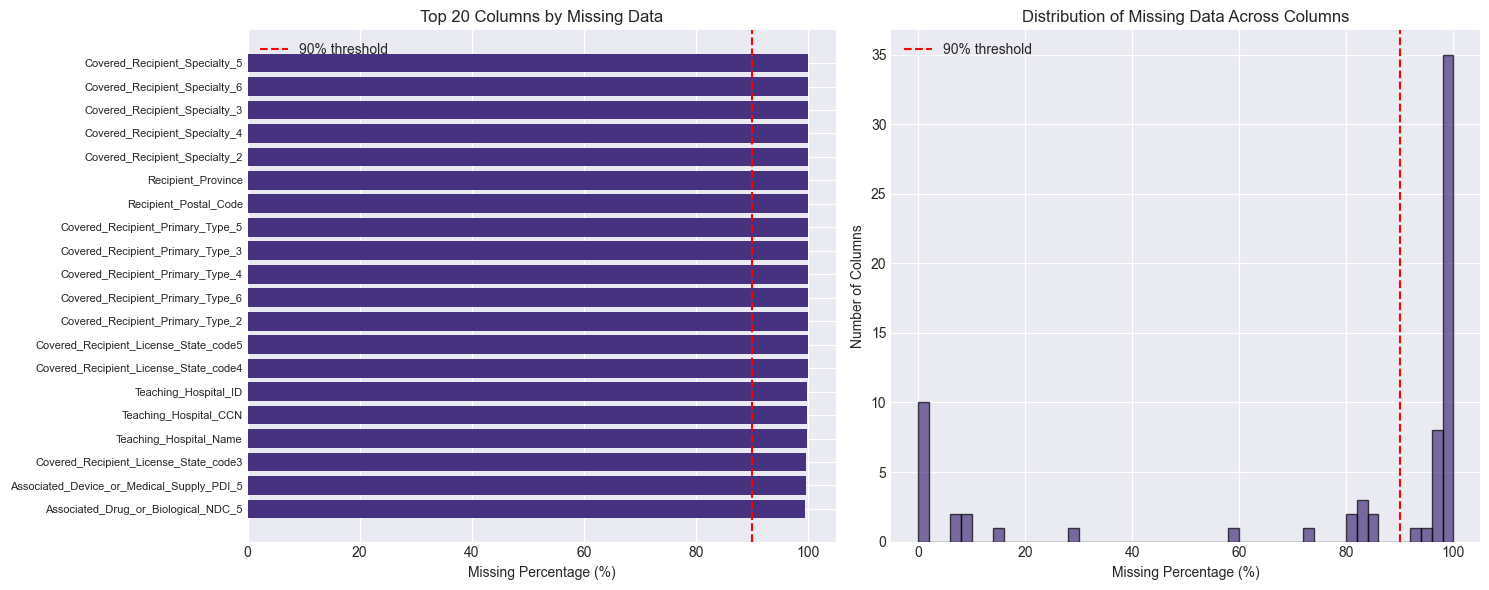

In [11]:
# Visualize missing data patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top 20 columns with missing data
top_missing = missing_df.head(20)
axes[0].barh(range(len(top_missing)), top_missing['Missing_Percent'])
axes[0].set_yticks(range(len(top_missing)))
axes[0].set_yticklabels(top_missing['Column'], fontsize=8)
axes[0].set_xlabel('Missing Percentage (%)')
axes[0].set_title('Top 20 Columns by Missing Data')
axes[0].axvline(x=90, color='red', linestyle='--', label='90% threshold')
axes[0].legend()
axes[0].invert_yaxis()

# Distribution of missingness across columns
axes[1].hist(missing_df['Missing_Percent'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Missing Percentage (%)')
axes[1].set_ylabel('Number of Columns')
axes[1].set_title('Distribution of Missing Data Across Columns')
axes[1].axvline(x=90, color='red', linestyle='--', label='90% threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Issue #4: Geographic Data Validation

In [12]:
# Analyze state codes
print("=" * 80)
print("GEOGRAPHIC DATA VALIDATION")
print("=" * 80)

state_col = 'Recipient_State' if 'Recipient_State' in df.columns else None

if state_col:
    print(f"\nAnalyzing column: {state_col}")
    
    # Count unique states
    unique_states = df[state_col].nunique()
    print(f"  Unique values: {unique_states}")
    print(f"  Missing values: {df[state_col].isnull().sum()}")
    
    # Valid US state codes (50 states + DC + territories)
    valid_states = [
        'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
        'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
        'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
        'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
        'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY',
        'DC', 'PR', 'VI', 'GU', 'AS', 'MP'  # Territories
    ]
    
    # Check for invalid codes
    state_values = df[state_col].dropna().unique()
    invalid_states = [s for s in state_values if s not in valid_states]
    
    print(f"\n  Valid state codes: {len([s for s in state_values if s in valid_states])}")
    print(f"  Invalid/Unknown codes: {len(invalid_states)}")
    
    if len(invalid_states) > 0:
        print(f"\nInvalid State Codes Found:")
        # Show frequency of invalid codes
        invalid_counts = df[df[state_col].isin(invalid_states)][state_col].value_counts().head(20)
        display(invalid_counts)
        
        print(f"\nRecommendation: Clean state codes - {len(invalid_counts)} invalid values")
    else:
        print(f"\nAll state codes are valid")
    
    # Top 10 states by record count
    print(f"\nTop 10 States by Record Count:")
    top_states = df[state_col].value_counts().head(10)
    display(top_states)
else:
    print("\nState column not found in dataset")

GEOGRAPHIC DATA VALIDATION

Analyzing column: Recipient_State
  Unique values: 58
  Missing values: 31

  Valid state codes: 56
  Invalid/Unknown codes: 2

Invalid State Codes Found:


Recipient_State
AE    40
AP    20
Name: count, dtype: int64


Recommendation: Clean state codes - 2 invalid values

Top 10 States by Record Count:


Recipient_State
TX    94386
CA    88691
FL    87796
NY    67150
PA    43333
OH    38762
GA    38522
NC    34773
IL    34007
NJ    33525
Name: count, dtype: int64

## 6. Summary & Recommendations

In [13]:
print("=" * 80)
print("INVESTIGATION SUMMARY & RECOMMENDATIONS")
print("=" * 80)

print("\nFINDINGS:")
print("\n1. PAYMENT OUTLIERS:")
if payments.max() > 100_000_000_000:
    print(f"CRITICAL: Extreme value detected (${payments.max():,.2f})")
    print(f"Likely data entry error or corruption")
else:
    print(f"Max payment: ${payments.max():,.2f}")
print(f"• IQR method flags {len(iqr_outliers)/len(payments)*100:.1f}% as outliers (too aggressive)")
print(f"• 99th percentile: ${payments.quantile(0.99):,.2f} (recommended threshold)")

print("\n2. MISSING DATA:")
print(f"• Overall: {missing_cells/total_cells*100:.1f}% of cells are missing")
print(f"• {len(empty_cols)} columns are completely empty (100% missing)")
print(f"• {len(missing_df[missing_df['Missing_Percent'] > 90])} columns have >90% missing data")

print("\n3. GEOGRAPHIC DATA:")
if state_col and len(invalid_states) > 0:
    print(f"{len(invalid_states)} invalid state codes detected")
    print(f"• Affects {df[df[state_col].isin(invalid_states)].shape[0]:,} records")
else:
    print(f"State codes appear valid")

print("\n" + "=" * 80)
print("RECOMMENDED ACTIONS:")
print("=" * 80)

print("\n1. OUTLIER HANDLING:")
print(f"Use percentile-based method (99th or 99.9th percentile)")
print(f"Cap extreme values at ${payments.quantile(0.999):,.2f} (99.9th percentile)")
print(f"Or apply log transformation for modeling")

print("\n2. MISSING DATA:")
print(f"Drop {len(empty_cols)} completely empty columns")
print(f"Consider dropping columns with >90% missing")
print(f"For payment amounts: decide if NaN = $0 or exclude from analysis")

print("\n3. GEOGRAPHIC CLEANING:")
if state_col and len(invalid_states) > 0:
    print(f"Map invalid state codes to valid ones or mark as 'Unknown'")
    print(f"Investigate numeric codes (e.g., '120') for possible encoding issues")

print("\n4. DISTRIBUTION:")
print(f"Apply log transformation: log10(payment + 1) for modeling")
print(f"Consider using robust scalers (RobustScaler) instead of StandardScaler")

print("\n" + "=" * 80)
print("Investigation Complete")
print("=" * 80)

INVESTIGATION SUMMARY & RECOMMENDATIONS

FINDINGS:

1. PAYMENT OUTLIERS:
Max payment: $13,180,782.34
• IQR method flags 16.5% as outliers (too aggressive)
• 99th percentile: $3,120.00 (recommended threshold)

2. MISSING DATA:
• Overall: 57.5% of cells are missing
• 5 columns are completely empty (100% missing)
• 45 columns have >90% missing data

3. GEOGRAPHIC DATA:
2 invalid state codes detected
• Affects 60 records

RECOMMENDED ACTIONS:

1. OUTLIER HANDLING:
Use percentile-based method (99th or 99.9th percentile)
Cap extreme values at $14,210.01 (99.9th percentile)
Or apply log transformation for modeling

2. MISSING DATA:
Drop 5 completely empty columns
Consider dropping columns with >90% missing
For payment amounts: decide if NaN = $0 or exclude from analysis

3. GEOGRAPHIC CLEANING:
Map invalid state codes to valid ones or mark as 'Unknown'
Investigate numeric codes (e.g., '120') for possible encoding issues

4. DISTRIBUTION:
Apply log transformation: log10(payment + 1) for modeli

## 7. Export Cleaned Dataset Recommendations

In [14]:
# Create a cleaned version applying recommendations
print("Creating cleaned dataset...")

df_clean = df.copy()

# 1. Drop completely empty columns
if len(empty_cols) > 0:
    cols_to_drop = empty_cols['Column'].tolist()
    df_clean = df_clean.drop(columns=cols_to_drop)
    print(f"Dropped {len(cols_to_drop)} empty columns")

# 2. Cap payment outliers at 99.9th percentile
cap_value = payments.quantile(0.999)
df_clean[payment_col] = df_clean[payment_col].clip(upper=cap_value)
print(f"Capped payments at ${cap_value:,.2f}")

# 3. Clean state codes (if needed)
if state_col and len(invalid_states) > 0:
    df_clean.loc[df_clean[state_col].isin(invalid_states), state_col] = 'UNKNOWN'
    print(f"Marked {len(invalid_states)} invalid state codes as 'UNKNOWN'")

print(f"\nCleaned dataset shape: {df_clean.shape}")
print(f"  Original columns: {df.shape[1]}")
print(f"  Cleaned columns: {df_clean.shape[1]}")
print(f"  Columns removed: {df.shape[1] - df_clean.shape[1]}")

# Optionally save
# df_clean.to_csv('../data/lightdataset_cleaned.csv', index=False)
# print("\nCleaned dataset saved to: ../data/lightdataset_cleaned.csv")

Creating cleaned dataset...
Dropped 5 empty columns
Capped payments at $14,210.01
Marked 2 invalid state codes as 'UNKNOWN'

Cleaned dataset shape: (1000000, 86)
  Original columns: 91
  Cleaned columns: 86
  Columns removed: 5
